In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import numpy as np
import pandas as pd
import xarray as xr
import pickle
from matplotlib import cm
from datetime import datetime

from datetime import datetime
from pyproj import Transformer
from scipy.ndimage import convolve
%run -i ncbx_funcs.py

In [2]:
# These commands choose fonts that are editable in svg format
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# colors
dblue = '#1f77b4'
red3 = ['#fee0d2','#fc9272','#de2d26']
# oranges from ColorBrewer https://colorbrewer2.org/#type=sequential&scheme=PuBu&n=5
cols=['#feedde','#fdbe85','#fd8d3c','#e6550d','#a63603']
blue5=['#f1eef6','#bdc9e1','#bdc9e1','#2b8cbe','#045a8d']
green5=['#edf8e9','#bae4b3','#74c476','#31a354','#006d2c']
purple5 = ['#f2f0f7','#cbc9e2','#9e9ac8','#756bb1','#54278f']
ored3 = ['#fee8c8','#fdbb84','#e34a33']

# This is the colormap made in SurferClr2Cmap.ipynb from NorthCore_ElevationShader_v2.clr
fp = open('cmap_ncb.pkl', 'rb')
cmap_ncb = pickle.load(fp)
fp.close()

# This makes NaN gray
tcmap=cm.terrain # This matches COFDL talk
# tcmap=cmap_ncb # This matches JGR
tcmap.set_bad(color='darkgray')

# tcmapw=cmap_ncb
# tcmapw.set_bad(color='white')

# This is the difference color map
dcmap = cm.seismic.copy()
dcmap.set_bad(color='darkgray')

# This is the difference color map
# dcmapw = cm.seismic.copy()
# dcmapw.set_bad(color='white')

ygbmap = cm.YlGnBu_r.copy()
ygbmap.set_bad(color='darkgray')

prmap = cm.PuRd.copy()
prmap.set_bad(color='darkgray')

#### Note from John Warner: how he did his volume calcs in Matlab
here is what i did to get those dorian volume calcs  
  
%first run this to get h_init  
url='http://geoport.whoi.edu/thredds/dodsC/vortexfs1/usgs/Projects/dorian/core_banks_jcw50/Output/Dorian_NCB_his_00001.nc';    %get h  
  
tidx=1; h=ncread(url,'bath',[1 1 tidx],[Inf Inf 1]);  
pm=ncread(url,'pm');  
pn=ncread(url,'pn');  
  
% now use these 4 urls  
url='http://geoport.whoi.edu/thredds/dodsC/vortexfs1/usgs/Projects/dorian/core_banks_jcw45/Output/Dorian_NCB_his_00019.nc';  %CSYV
url='http://geoport.whoi.edu/thredds/dodsC/vortexfs1/usgs/Projects/dorian/core_banks_jcw44/Output/Dorian_NCB_his_00019.nc';  %CSNV
url='http://geoport.whoi.edu/thredds/dodsC/vortexfs1/usgs/Projects/dorian/core_banks_jcw50/Output/Dorian_NCB_his_00019.nc';  %FSYV
url='http://geoport.whoi.edu/thredds/dodsC/vortexfs1/usgs/Projects/dorian/core_banks_jcw51/Output/Dorian_NCB_his_00019.nc';  %FSNV
%  
%  for each of the 4 urls above, i ran this code:  
  
tidx=4; bath_end=ncread(url,'bath',[1 1 tidx],[Inf Inf 1]);  
  
%conservative estimate Left:  
istr=830; iend=900;  
jstr=180; jend=430;  
zz=(bath_end(istr:iend,jstr:jend)-h(istr:iend,jstr:jend))./pm(istr:iend,jstr:jend)./pn(istr:iend,jstr:jend);  
sed_loss=sum(sum(zz))  
%69573 m3 right /(950-800) = 70 *1.5m = 105 =   662 m3/m  
  
%conservative estimate RIGHT:  
istr=380; iend=480;  
jstr=180; jend=430;  
zz=(bath_end(istr:iend,jstr:jend)-h(istr:iend,jstr:jend))./pm(istr:iend,jstr:jend)./pn(istr:iend,jstr:jend);  
sed_loss=sum(sum(zz))  
%62175 m3  left/(480-380) = 100 *1.5m = 150 =   414 m3/m  
  
  
sim  left(tot , m3/m)   right(tot , m3/m)  
45    62,175   414       69,573     662  
44    75,755   505       87,293     831  
50    77,335   515       97,836     434  
51    96,030   640       151,720    674  

In [3]:
# load inital bathy
url='http://geoport.whoi.edu/thredds/dodsC/vortexfs1/usgs/Projects/dorian/core_banks_jcw50/Output/Dorian_NCB_his_00001.nc'
ds_init = xr.open_dataset(url)
bathi = -ds_init.bath[0,:,:].load().values
pm = ds_init.pm[:,:].load().values
pn = ds_init.pn[:,:].load().values
init_time = ds_init.ocean_time[0].load().values
print('Initial time: ',init_time)

# load final bathy for four cases
tidx = -1 # last file
url_CSYV='http://geoport.whoi.edu/thredds/dodsC/vortexfs1/usgs/Projects/dorian/core_banks_jcw45/Output/Dorian_NCB_his_00019.nc'
ds_CSYV = xr.open_dataset(url_CSYV)
bathf_CSYV = -ds_CSYV.bath[tidx,:,:].load().values
final_time = ds_CSYV.ocean_time[tidx].load().values
print('Final time: ',final_time)

url_CSNV='http://geoport.whoi.edu/thredds/dodsC/vortexfs1/usgs/Projects/dorian/core_banks_jcw44/Output/Dorian_NCB_his_00019.nc'
ds_CSNV = xr.open_dataset(url_CSNV)
bathf_CSNV = -ds_CSNV.bath[tidx,:,:].load().values

url_FSYV='http://geoport.whoi.edu/thredds/dodsC/vortexfs1/usgs/Projects/dorian/core_banks_jcw50/Output/Dorian_NCB_his_00019.nc'
ds_FSYV = xr.open_dataset(url_FSYV)
bathf_FSYV = -ds_FSYV.bath[tidx,:,:].load().values

url_FSNV='http://geoport.whoi.edu/thredds/dodsC/vortexfs1/usgs/Projects/dorian/core_banks_jcw51/Output/Dorian_NCB_his_00019.nc'
ds_FSNV = xr.open_dataset(url_FSNV)
bathf_FSNV = -ds_FSNV.bath[tidx,:,:].load().values

Initial time:  2019-09-06T00:00:00.000000000
Final time:  2019-09-06T19:00:00.060924928


Left CSYV: -61886, -413
Left CSNV: -75328, -502
Left FSYV: -76906, -513
Left FSNV: -95346, -636
Right CSYV: -69307, -660
Right CSNV: -86821, -827
Right FSYV: -78371, -746
Right FSNV: -112309, -1070


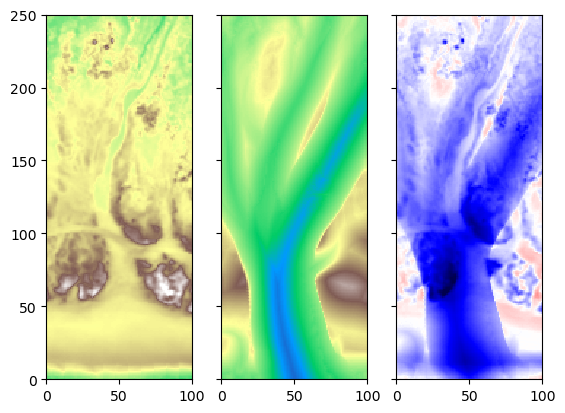

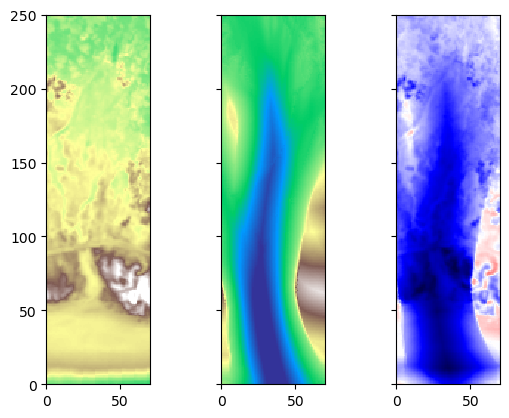

In [4]:
# conservative estimate left (John's right):
istr=380
iend=480
jstr=180
jend=430
i = -1 # offset for converting Matlab indexing to Python indexing. Should be -1, but experimenting

# note indices are reversed in Python, and index from zero
zi = bathi[jstr+i:jend+i,istr+i:iend+i]
zf_CSYV = bathf_CSYV[jstr+i:jend+i,istr+i:iend+i]
Lsed_loss_CSYV = (zf_CSYV - zi) / pm[jstr+i:jend+i,istr+i:iend+i] / pn[jstr+i:jend+i,istr+i:iend+i]
print('Left CSYV: {:.0f}, {:.0f}'.format( np.sum(Lsed_loss_CSYV), np.sum(Lsed_loss_CSYV)/((iend-istr)*1.5) ) )

zf_CSNV = bathf_CSNV[jstr+i:jend+i,istr+i:iend+i]
Lsed_loss_CSNV = (zf_CSNV - zi) / pm[jstr+i:jend+i,istr+i:iend+i] / pn[jstr+i:jend+i,istr+i:iend+i]
print('Left CSNV: {:.0f}, {:.0f}'.format( np.sum(Lsed_loss_CSNV), np.sum(Lsed_loss_CSNV)/((iend-istr)*1.5) ) )

zf_FSYV = bathf_FSYV[jstr+i:jend+i,istr+i:iend+i]
Lsed_loss_FSYV = (zf_FSYV - zi) / pm[jstr+i:jend+i,istr+i:iend+i] / pn[jstr+i:jend+i,istr+i:iend+i]
print('Left FSYV: {:.0f}, {:.0f}'.format( np.sum(Lsed_loss_FSYV), np.sum(Lsed_loss_FSYV)/((iend-istr)*1.5) ) )

zf_FSNV = bathf_FSNV[jstr+i:jend+i,istr+i:iend+i]
Lsed_loss_FSNV = (zf_FSNV - zi) / pm[jstr+i:jend+i,istr+i:iend+i] / pn[jstr+i:jend+i,istr+i:iend+i]
print('Left FSNV: {:.0f}, {:.0f}'.format( np.sum(Lsed_loss_FSNV), np.sum(Lsed_loss_FSNV)/((iend-istr)*1.5) ) )

fig, axs = plt.subplots(1, 3, sharey=True)
axs[0].pcolormesh( zi, cmap=tcmap, vmin = -2., vmax = 5 )
axs[0].set_aspect('equal', adjustable='box')
axs[1].pcolormesh( zf_CSYV, cmap=tcmap, vmin = -2., vmax = 5 )
axs[1].set_aspect('equal', adjustable='box')
axs[2].pcolormesh( zf_CSYV - zi, cmap=dcmap, vmin = -5., vmax = 5 )
axs[2].set_aspect('equal', adjustable='box')

# conservative estimate right (John's left):
istr=830
iend=900
jstr=180
jend=430
i = -1 # offset for converting Matlab indexing to Python indexing. Should be -1, but experimenting

# note indices are reversed in Python, and index from zero
zi = bathi[jstr+i:jend+i,istr+i:iend+i]
zf_CSYV = bathf_CSYV[jstr+i:jend+i,istr+i:iend+i]
Rsed_loss_CSYV = (zf_CSYV - zi) / pm[jstr+i:jend+i,istr+i:iend+i] / pn[jstr+i:jend+i,istr+i:iend+i]
print('Right CSYV: {:.0f}, {:.0f}'.format( np.sum(Rsed_loss_CSYV), np.sum(Rsed_loss_CSYV)/((iend-istr)*1.5) ) )

zf_CSNV = bathf_CSNV[jstr+i:jend+i,istr+i:iend+i]
Rsed_loss_CSNV = (zf_CSNV - zi) / pm[jstr+i:jend+i,istr+i:iend+i] / pn[jstr+i:jend+i,istr+i:iend+i]
print('Right CSNV: {:.0f}, {:.0f}'.format( np.sum(Rsed_loss_CSNV), np.sum(Rsed_loss_CSNV)/((iend-istr)*1.5) ) )

zf_FSYV = bathf_FSYV[jstr+i:jend+i,istr+i:iend+i]
Rsed_loss_FSYV = (zf_FSYV - zi) / pm[jstr+i:jend+i,istr+i:iend+i] / pn[jstr+i:jend+i,istr+i:iend+i]
print('Right FSYV: {:.0f}, {:.0f}'.format( np.sum(Rsed_loss_FSYV), np.sum(Rsed_loss_FSYV)/((iend-istr)*1.5) ) )

zf_FSNV = bathf_FSNV[jstr+i:jend+i,istr+i:iend+i]
Rsed_loss_FSNV = (zf_FSNV - zi) / pm[jstr+i:jend+i,istr+i:iend+i] / pn[jstr+i:jend+i,istr+i:iend+i]
print('Right FSNV: {:.0f}, {:.0f}'.format( np.sum(Rsed_loss_FSNV), np.sum(Rsed_loss_FSNV)/((iend-istr)*1.5) ) )

fig, axs = plt.subplots(1, 3, sharey=True)
axs[0].pcolormesh( zi, cmap=tcmap, vmin = -2., vmax = 5 )
axs[0].set_aspect('equal', adjustable='box')
axs[1].pcolormesh( zf_CSYV, cmap=tcmap, vmin = -2., vmax = 5 )
axs[1].set_aspect('equal', adjustable='box')
axs[2].pcolormesh( zf_CSYV - zi, cmap=dcmap, vmin = -5., vmax = 5 )
axs[2].set_aspect('equal', adjustable='box')

# sim left(tot , m3/m) right(tot , m3/m)
# 45 62,175 414 69,573 662
# 44 75,755 505 87,293 831
# 50 77,335 515 97,836 434
# 51 96,030 640 151,720 674

In [5]:
# load the pre- post- observations
# This does not have the same shape as John's model files.
# According to John, the model grid extened this file by adding 
url = '/vortexfs1/home/csherwood/proj/dorian/NCoreBanks_sub9_pre_post_veg.nc'
ds_obs = xr.open_dataset(url)
ds_obs
url = '/vortexfs1/home/csherwood/proj/dorian/NCoreBanks_sub9_pre_post_vegv2.nc'
ds_obsv2 = xr.open_dataset(url)
ds_obsv2

<xarray.Dataset>
Dimensions:           (one: 1, bath: 1, eta_rho: 1017, xi_rho: 1317,
                       eta_psi: 1016, xi_psi: 1316, eta_u: 1017, xi_u: 1316,
                       eta_v: 1016, xi_v: 1317)
Dimensions without coordinates: one, bath, eta_rho, xi_rho, eta_psi, xi_psi,
                                eta_u, xi_u, eta_v, xi_v
Data variables: (12/37)
    xl                (one) float64 ...
    el                (one) float64 ...
    JPRJ              |S2 ...
    spherical         (one) |S1 ...
    depthmin          (one) int16 ...
    depthmax          (one) int16 ...
    ...                ...
    mask_v            (eta_v, xi_v) float64 ...
    mask_psi          (eta_psi, xi_psi) float64 ...
    angle             (eta_rho, xi_rho) float64 ...
    canopy_height     (eta_rho, xi_rho) float64 ...
    pre_Dorian_elev   (eta_rho, xi_rho) float64 ...
    post_Dorian_elev  (eta_rho, xi_rho) float64 ...
Attributes:
    type:     ROMS GRID file
    gridid:   theGridTitle
    history:  Created by create_roms_netcdf_grid_file, on 02-Sep-2021 12:34:2...
    title:    ROMS Application

### Compare various incarnations of the initial topo/bathy
It looks like the `h` in the grid file is not the same as the first `bath` array.  

In [26]:
# this is the bathy from the first  and last time step of the .his files
bathis = bathi[40:,:]
bathfs = bathf_CSYV[40:,:]

# this is the bathy in the grid file
h_init = ds_obsv2.h[:,:]
print(np.shape(bathis))
print(np.shape(h_init))

# These topos were exported from GM with 8-bit resolution
# h_pre_obs = ds_obs.pre_Dorian_elev[:,:]
# h_pst_obs = ds_obs.post_Dorian_elev[:,:]

# This version uses full 32-bit for elevation
h_pre_obs = ds_obsv2.pre_Dorian_elev[:,:]
h_pst_obs = ds_obsv2.post_Dorian_elev[:,:]

x = ds_obsv2.xi_rho
y = ds_obsv2.eta_rho

(1017, 1317)
(1017, 1317)


Text(0.5, 1.0, '-h[40:,:] from NCoreBanks_sub9_pre_post_vegv2.nc')

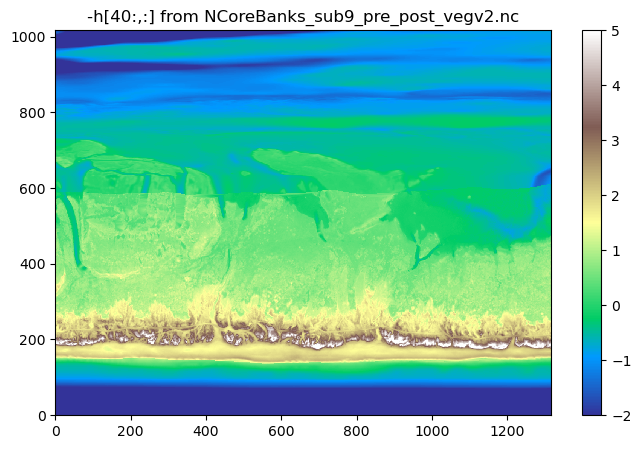

In [7]:
fig, ax = plt.subplots(1,1,figsize=(8,5),sharex=True)
t0 = ax.pcolormesh(x,y,-h_init, cmap=tcmap, vmin = -2., vmax = 5 )
plt.colorbar(t0, ax=ax)
plt.title('-h[40:,:] from NCoreBanks_sub9_pre_post_vegv2.nc')

Text(0.5, 1.0, '-bath[0,40:,:] core_banks_jcw50/Output/Dorian_NCB_his_00001.nc')

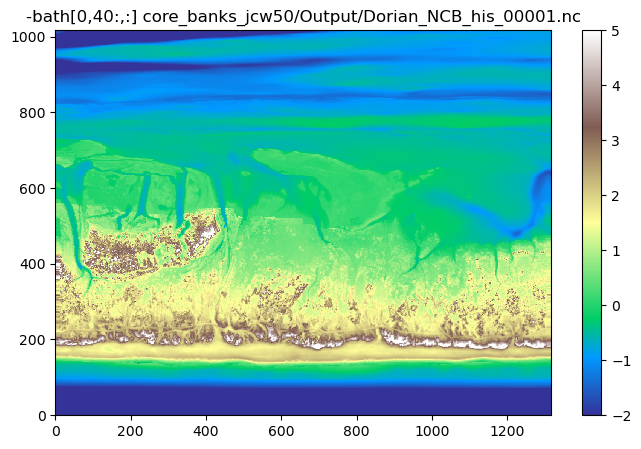

In [8]:
fig, ax = plt.subplots(1,1,figsize=(8,5),sharex=True)
t0 = ax.pcolormesh(x,y,bathis, cmap=tcmap, vmin = -2., vmax = 5 )
plt.colorbar(t0, ax=ax)
plt.title('-bath[0,40:,:] core_banks_jcw50/Output/Dorian_NCB_his_00001.nc')

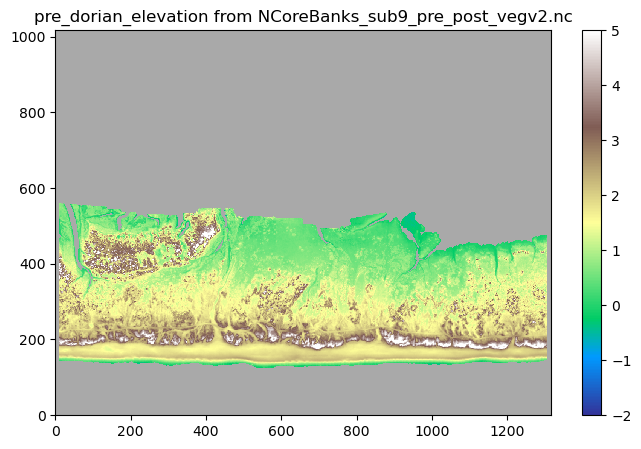

In [9]:
fig, ax = plt.subplots(1,1,figsize=(8,5),sharex=True)
t0 = ax.pcolormesh(x,y,h_pre_obsv2, cmap=tcmap, vmin = -2., vmax = 5 )
plt.title('pre_dorian_elevation from NCoreBanks_sub9_pre_post_vegv2.nc')
plt.colorbar(t0, ax=ax)

### Draw boxes for volume calcs

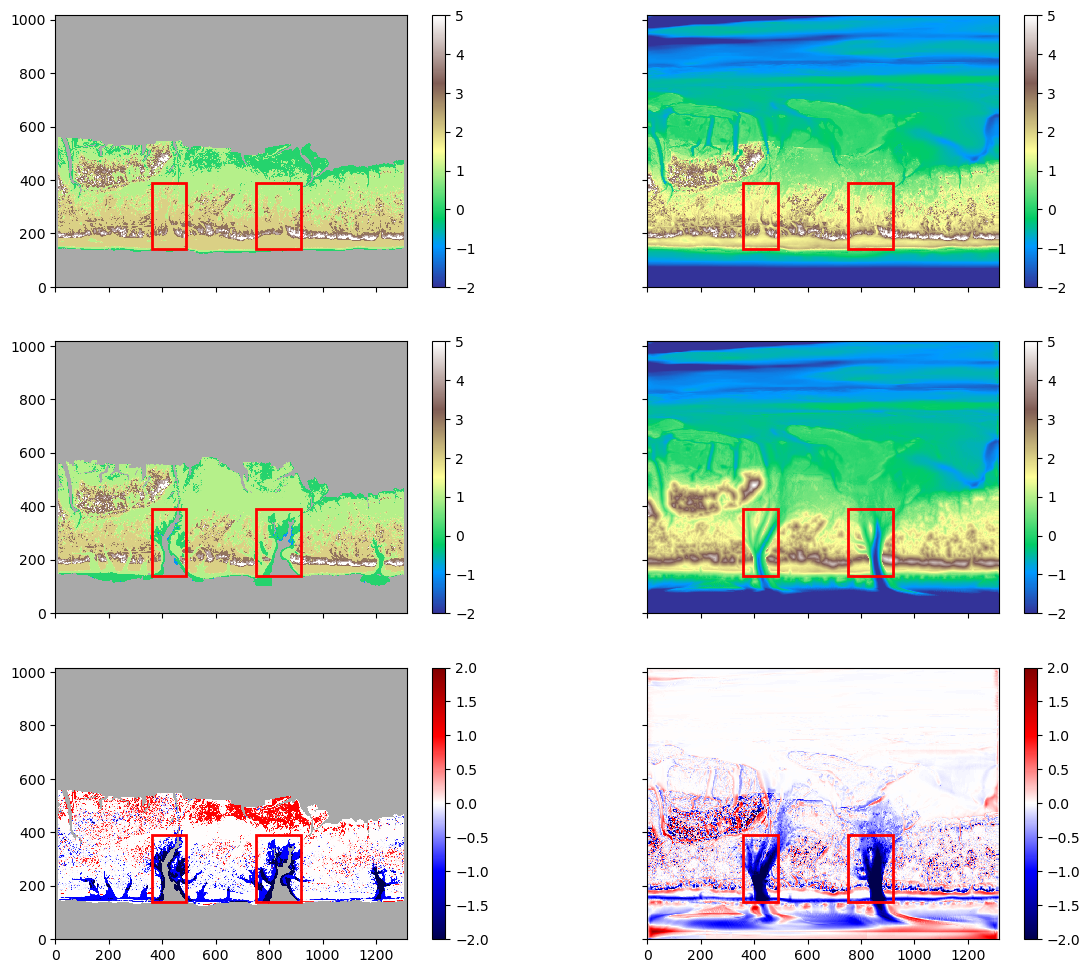

In [11]:
# draw boxes on observational data
# Johns original boxes
# listr=380
# liend=480
# ljstr=180-40
# ljend=430-40

# ristr=830
# riend=900
# rjstr=180-40
# rjend=430-40

# my revised boxes
ristr=750
riend=920
rjstr=180-40
rjend=430-40

listr=360
liend=490
ljstr=180-40
ljend=430-40

fig, ax = plt.subplots(3,2,figsize=(14,12),sharex=True, sharey=True)
t00 = ax[0][0].pcolormesh(x,y,h_pre_obs, cmap=tcmap, vmin = -2., vmax = 5 )
rect0r = patches.Rectangle((ristr,rjstr),riend-ristr,rjend-rjstr, linewidth=2, edgecolor='r', facecolor='none')
ax[0][0].add_patch(rect0r)
rect0l = patches.Rectangle((listr,ljstr),liend-listr,ljend-ljstr, linewidth=2, edgecolor='r', facecolor='none')
ax[0][0].add_patch(rect0l)
ax[0][0].set_aspect('equal', adjustable='box')
plt.colorbar(t00, ax=ax[0][0])

t10 = ax[1][0].pcolormesh(x,y,h_pst_obs, cmap=tcmap, vmin = -2., vmax = 5 )
rect1r = patches.Rectangle((ristr,rjstr),riend-ristr,rjend-rjstr, linewidth=2, edgecolor='r', facecolor='none')
ax[1][0].add_patch(rect1r)
rect1l = patches.Rectangle((listr,ljstr),liend-listr,ljend-ljstr, linewidth=2, edgecolor='r', facecolor='none')
ax[1][0].add_patch(rect1l)
ax[1][0].set_aspect('equal', adjustable='box')
plt.colorbar(t10, ax=ax[1][0])

dm0=ax[2][0].pcolormesh(x,y,h_pst_obs-h_pre_obs, cmap=dcmap, vmin = -2., vmax = 2 )
rect2r = patches.Rectangle((ristr,rjstr),riend-ristr,rjend-rjstr, linewidth=2, edgecolor='r', facecolor='none')
ax[2][0].add_patch(rect2r)
rect2l = patches.Rectangle((listr,ljstr),liend-listr,ljend-ljstr, linewidth=2, edgecolor='r', facecolor='none')
ax[2][0].add_patch(rect2l)
ax[2][0].set_aspect('equal', adjustable='box')
plt.colorbar(dm0, ax=ax[2][0])



t01 = ax[0][1].pcolormesh(x,y,bathis, cmap=tcmap, vmin = -2., vmax = 5 )
rect0r = patches.Rectangle((ristr,rjstr),riend-ristr,rjend-rjstr, linewidth=2, edgecolor='r', facecolor='none')
ax[0][1].add_patch(rect0r)
rect0l = patches.Rectangle((listr,ljstr),liend-listr,ljend-ljstr, linewidth=2, edgecolor='r', facecolor='none')
ax[0][1].add_patch(rect0l)
ax[0][1].set_aspect('equal', adjustable='box')
plt.colorbar(t01, ax=ax[0][1])

t11 = ax[1][1].pcolormesh(x,y,bathfs, cmap=tcmap, vmin = -2., vmax = 5 )
rect1r = patches.Rectangle((ristr,rjstr),riend-ristr,rjend-rjstr, linewidth=2, edgecolor='r', facecolor='none')
ax[1][1].add_patch(rect1r)
rect1l = patches.Rectangle((listr,ljstr),liend-listr,ljend-ljstr, linewidth=2, edgecolor='r', facecolor='none')
ax[1][1].add_patch(rect1l)
ax[1][1].set_aspect('equal', adjustable='box')
plt.colorbar(t11, ax=ax[1][1])

dm1=ax[2][1].pcolormesh(x,y,bathfs-bathis, cmap=dcmap, vmin = -2., vmax = 2 )
rect2r = patches.Rectangle((ristr,rjstr),riend-ristr,rjend-rjstr, linewidth=2, edgecolor='r', facecolor='none')
ax[2][1].add_patch(rect2r)
rect2l = patches.Rectangle((listr,ljstr),liend-listr,ljend-ljstr, linewidth=2, edgecolor='r', facecolor='none')
ax[2][1].add_patch(rect2l)
ax[2][1].set_aspect('equal', adjustable='box')
plt.colorbar(dm1, ax=ax[2][1])

### Redo volume calcs for these boxes

Left CSYV: -58120, -298
Left CSNV: -73988, -379
Left FSYV: -75070, -385
Left FSNV: -96693, -496
Right CSYV: -70069, -275
Right CSNV: -98435, -386
Right FSYV: -81979, -321
Right FSNV: -139188, -546


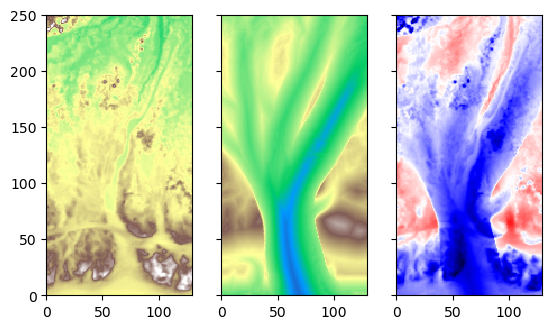

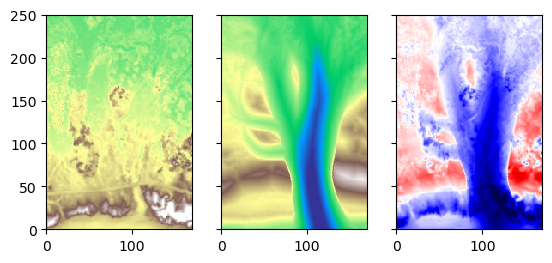

In [20]:
# Left box
# note indices are reversed in Python, and index from zero
i = 40
Lzi = bathis[ljstr+i:ljend+i,listr:liend]
Lzf_CSYV = bathf_CSYV[ljstr+i:ljend+i,listr:liend]
Lsed_loss_CSYV = (Lzf_CSYV - Lzi) / pm[ljstr+i:ljend+i,listr:liend] / pn[ljstr+i:ljend+i,listr:liend]
print('Left CSYV: {:.0f}, {:.0f}'.format( np.sum(Lsed_loss_CSYV), np.sum(Lsed_loss_CSYV)/((liend-listr)*1.5) ) )

Lzf_CSNV = bathf_CSNV[ljstr+i:ljend+i,listr:liend]
Lsed_loss_CSNV = (Lzf_CSNV - Lzi) / pm[ljstr+i:ljend+i,listr:liend] / pn[ljstr+i:ljend+i,listr:liend]
print('Left CSNV: {:.0f}, {:.0f}'.format( np.sum(Lsed_loss_CSNV), np.sum(Lsed_loss_CSNV)/((liend-listr)*1.5) ) )

Lzf_FSYV = bathf_FSYV[ljstr+i:ljend+i,listr:liend]
Lsed_loss_FSYV = (Lzf_FSYV - Lzi) / pm[ljstr+i:ljend+i,listr:liend] / pn[ljstr+i:ljend+i,listr:liend]
print('Left FSYV: {:.0f}, {:.0f}'.format( np.sum(Lsed_loss_FSYV), np.sum(Lsed_loss_FSYV)/((liend-listr)*1.5) ) )

Lzf_FSNV = bathf_FSNV[ljstr+i:ljend+i,listr:liend]
Lsed_loss_FSNV = (Lzf_FSNV - Lzi) / pm[ljstr+i:ljend+i,listr:liend] / pn[ljstr+i:ljend+i,listr:liend]
print('Left FSNV: {:.0f}, {:.0f}'.format( np.sum(Lsed_loss_FSNV), np.sum(Lsed_loss_FSNV)/((liend-listr)*1.5) ) )

fig, axs = plt.subplots(1, 3, sharey=True)
axs[0].pcolormesh( Lzi, cmap=tcmap, vmin = -2., vmax = 5 )
axs[0].set_aspect('equal', adjustable='box')
axs[1].pcolormesh( Lzf_CSYV, cmap=tcmap, vmin = -2., vmax = 5 )
axs[1].set_aspect('equal', adjustable='box')
axs[2].pcolormesh( Lzf_CSYV - Lzi, cmap=dcmap, vmin = -5., vmax = 5 )
axs[2].set_aspect('equal', adjustable='box')

# conservative estimate right (John's left):
Rzi = bathis[rjstr+i:rjend+i,ristr:riend]
Rzf_CSYV = bathf_CSYV[rjstr+i:rjend+i,ristr:riend]
Rsed_loss_CSYV = (Rzf_CSYV - Rzi) / pm[rjstr+i:rjend+i,ristr:riend] / pn[rjstr+i:rjend+i,ristr:riend]
print('Right CSYV: {:.0f}, {:.0f}'.format( np.sum(Rsed_loss_CSYV), np.sum(Rsed_loss_CSYV)/((riend-ristr)*1.5) ) )

Rzf_CSNV = bathf_CSNV[rjstr+i:rjend+i,ristr:riend]
Rsed_loss_CSNV = (Rzf_CSNV - Rzi) / pm[rjstr+i:rjend+i,ristr:riend] / pn[rjstr+i:rjend+i,ristr:riend]
print('Right CSNV: {:.0f}, {:.0f}'.format( np.sum(Rsed_loss_CSNV), np.sum(Rsed_loss_CSNV)/((riend-ristr)*1.5) ) )

Rzf_FSYV = bathf_FSYV[rjstr+i:rjend+i,ristr:riend]
Rsed_loss_FSYV = (Rzf_FSYV - Rzi) / pm[rjstr+i:rjend+i,ristr:riend] / pn[rjstr+i:rjend+i,ristr:riend]
print('Right FSYV: {:.0f}, {:.0f}'.format( np.sum(Rsed_loss_FSYV), np.sum(Rsed_loss_FSYV)/((riend-ristr)*1.5) ) )

Rzf_FSNV = bathf_FSNV[rjstr+i:rjend+i,ristr:riend]
Rsed_loss_FSNV = (Rzf_FSNV - Rzi) / pm[rjstr+i:rjend+i,ristr:riend] / pn[rjstr+i:rjend+i,ristr:riend]
print('Right FSNV: {:.0f}, {:.0f}'.format( np.sum(Rsed_loss_FSNV), np.sum(Rsed_loss_FSNV)/((riend-ristr)*1.5) ) )

fig, axs = plt.subplots(1, 3, sharey=True)
axs[0].pcolormesh( Rzi, cmap=tcmap, vmin = -2., vmax = 5 )
axs[0].set_aspect('equal', adjustable='box')
axs[1].pcolormesh( Rzf_CSYV, cmap=tcmap, vmin = -2., vmax = 5 )
axs[1].set_aspect('equal', adjustable='box')
axs[2].pcolormesh( Rzf_CSYV - Rzi, cmap=dcmap, vmin = -5., vmax = 5 )
axs[2].set_aspect('equal', adjustable='box')

# sim left(tot , m3/m) right(tot , m3/m)
# 45 62,175 414 69,573 662
# 44 75,755 505 87,293 831
# 50 77,335 515 97,836 434
# 51 96,030 640 151,720 674

### Now do the same calcs for the observations

In [75]:
# Left box
# note indices are reversed in Python, and index from zero
io = 0
Lozi = h_pre_obs[ljstr+io:ljend+io,listr:liend].values
Lozf = h_pst_obs[ljstr+io:ljend+io,listr:liend].values
Rozi = h_pre_obs[rjstr+io:rjend+io,ristr:riend].values
Rozf = h_pst_obs[rjstr+io:rjend+io,ristr:riend].values

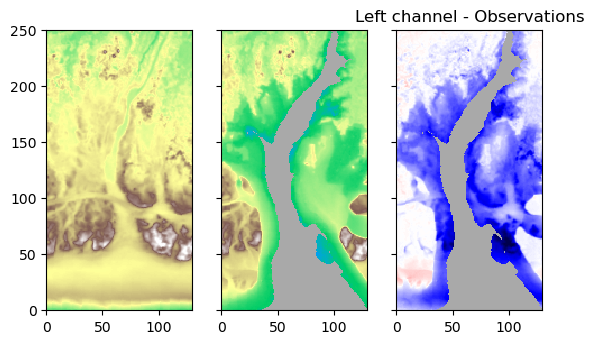

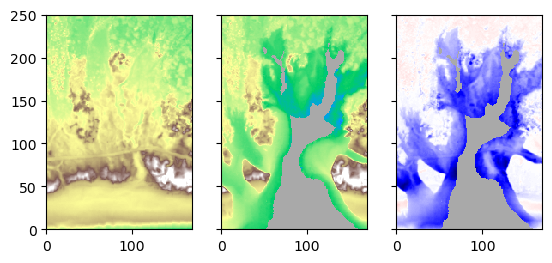

In [61]:
fig, axs = plt.subplots(1, 3, sharey=True)
axs[0].pcolormesh( Lozi, cmap=tcmap, vmin = -2., vmax = 5 )
axs[0].set_aspect('equal', adjustable='box')
axs[1].pcolormesh( Lozf, cmap=tcmap, vmin = -2., vmax = 5 )
axs[1].set_aspect('equal', adjustable='box')
axs[2].pcolormesh( Lozf - Lozi, cmap=dcmap, vmin = -5., vmax = 5 )
axs[2].set_aspect('equal', adjustable='box')
plt.title('Left channel - Observations')

fig, axs = plt.subplots(1, 3, sharey=True)
axs[0].pcolormesh( Rozi, cmap=tcmap, vmin = -2., vmax = 5 )
axs[0].set_aspect('equal', adjustable='box')
axs[1].pcolormesh( Rozf, cmap=tcmap, vmin = -2., vmax = 5 )
axs[1].set_aspect('equal', adjustable='box')
axs[2].pcolormesh( Rozf - Rozi, cmap=dcmap, vmin = -5., vmax = 5 )
axs[2].set_aspect('equal', adjustable='box')

In [64]:
print('With NaNs:')
Lsed_loss_obs = (Lozf - Lozi) / pm[ljstr+io:ljend+io,listr:liend] / pn[ljstr+io:ljend+io,listr:liend]
print('Left Obs: {:.0f}, {:.0f}'.format( np.nansum(Lsed_loss_obs), np.nansum(Lsed_loss_obs)/((liend-listr)*1.5) ) )
Rsed_loss_obs = (Rozf - Rozi) / pm[rjstr+io:rjend+io,ristr:riend] / pn[rjstr+io:rjend+io,ristr:riend]
print('Right Obs: {:.0f}, {:.0f}'.format( np.nansum(Rsed_loss_obs), np.nansum(Rsed_loss_obs)/((riend-ristr)*1.5) ) )

With NaNs:
Left Obs: -54792, -281
Right Obs: -60580, -238


In [94]:

nanval = -0
print( np.sum( np.isnan( Lozf )), np.nansum( Lozf ) )
Lozfn = Lozf.copy()
Lozfn[np.isnan(Lozf)] = nanval
print( np.sum( np.isnan( Lozfn2 )), np.sum( Lozfn) )

Rozfn = Rozf.copy()
print( np.sum( np.isnan( Rozf )), np.nansum( Rozf ) )
Rozfn[np.isnan(Rozf)] = nanval
print( np.sum( np.isnan( Rozfn )), np.sum( Rozfn) )

7508 22159.13566251781
0 22159.13566251781
7756 33285.761018188554
0 33285.761018188554


In [95]:
print('With ',nanval)
Lsed_loss_obsn = (Lozfn - Lozi) / pm[ljstr+io:ljend+io,listr:liend] / pn[ljstr+io:ljend+io,listr:liend]
print('Left Obs: {:.0f}, {:.0f}'.format( np.nansum(Lsed_loss_obsn), np.nansum(Lsed_loss_obsn)/((liend-listr)*1.5) ) )
Rsed_loss_obsn = (Rozfn - Rozi) / pm[rjstr+io:rjend+io,ristr:riend] / pn[rjstr+io:rjend+io,ristr:riend]
print('Right Obs: {:.0f}, {:.0f}'.format( np.nansum(Rsed_loss_obsn), np.nansum(Rsed_loss_obsn)/((riend-ristr)*1.5) ) )

With  0
Left Obs: -84790, -435
Right Obs: -91707, -360
